In [114]:
!pip install Sastrawi
!pip install nlp-id
!pip install wordcloud
!pip install textblob
!pip install translate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [translate]


In [101]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nlp_id.lemmatizer import Lemmatizer
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from textblob import Word
import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ahmadnafim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [102]:
df = pd.read_csv("../data/hasil_scraping_demo/fix_scarap/cleaned_data.csv")

In [103]:
df

,created_at,favorite_count,full_text,quote_count,reply_count,retweet_count,hashtags,cleaned_text
0,Sun Aug 31 14:43:43 +0000 2025,5677,Menyikapi pernyataan Prabowo bersama dengan pi...,54,87,3660,[],menyikapi pernyataan prabowo bersama dengan pi...
1,Sun Aug 31 10:11:46 +0000 2025,7435,Saudara-saudari sebangsa dan setanah air Negar...,4037,4287,1575,[],saudarasaudari sebangsa dan setanah air negara...
2,Fri Aug 29 06:27:34 +0000 2025,14161,Ringkasan Pernyataan Presiden: 1. Menuduh demo...,2003,709,14116,[],ringkasan pernyataan presiden menuduh demonst...
3,Sat Aug 30 10:34:24 +0000 2025,4806,Musuh kita bukan fasilitas umum. Bukan perbeda...,34,65,1939,[],musuh kita bukan fasilitas umum bukan perbedaa...
4,Sat Aug 30 06:44:02 +0000 2025,306,R E Q U I E M ● Brutalitas aparat bukan saja p...,1,30,93,[],requiem brutalitas aparat bukan saja problem ...
...,...,...,...,...,...,...,...,...
1218,Thu Aug 28 07:51:29 +0000 2025,2541,Hari ini mahasiswa melakukan aksi demo lagi di...,17,41,562,[],hari ini mahasiswa melakukan aksi demo lagi di...
1219,Fri Aug 29 11:33:23 +0000 2025,1557,Demo Bubarkan DPR Evaluasi Pejabat Korup dan T...,15,23,540,[],demo bubarkan dpr evaluasi pejabat korup dan t...
1220,Mon Aug 25 05:43:50 +0000 2025,4135,Pantauan Demo di Gedung DPR RI tanggal 25 Agus...,48,49,1120,[],pantauan demo di gedung dpr ri tanggal agustu...
1221,Sun Aug 31 22:36:49 +0000 2025,4441,SEPULUH TUNTUTAN RAKYAT UNTUK INDONESIA (SEPUL...,65,299,2135,[],sepuluh tuntutan rakyat untuk indonesia sepult...


In [104]:
def plot_wordcloud(texts:list):
    text = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud", fontsize=16)
    plt.show()

def plot_top_words(texts:list, n:int=10):
    all_words = " ".join(texts).split()
    counter = Counter(all_words)
    most_common = counter.most_common(n)

    words = [w for w, _ in most_common]
    freqs = [f for _, f in most_common]

    plt.figure(figsize=(8,5))
    plt.barh(words[::-1], freqs[::-1])
    plt.xlabel("Frekuensi")
    plt.title(f"Top {n} Kata Paling Sering Muncul")
    plt.show()


In [105]:
def dict_database(df, kolom_input, kolom_output, path_kamus_alay, path_stopwords, path_abusive, kamus_manual={}):
    try:
        kamus_alay_df = pd.read_csv(path_kamus_alay, header=None, names=['alay', 'baku'], encoding='latin1')
        kamus_dari_file = dict(zip(kamus_alay_df['alay'], kamus_alay_df['baku']))
        
        kamus_lengkap = {**kamus_dari_file, **kamus_manual}
        
        with open(path_stopwords, 'r') as file:
            stop_words = set(line.strip() for line in file)

        # TAMBAHKAN BARIS INI untuk menghapus kata 'ri'
        stop_words.add('ri')

        with open(path_abusive, 'r') as file:
            abusive_words = set(line.strip() for line in file)
            
    except FileNotFoundError as e:
        print(f"Error: File resource tidak ditemukan - {e.filename}. Proses dibatalkan.")
        return df

    def proses_pembersihan_teks(text):
        text = str(text).lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', text)
        text = re.sub(r'[^a-z\s]', '', text)
        
        tokens = text.split()
        
        cleaned_tokens = []
        for token in tokens:
            token = kamus_lengkap.get(token, token)
            if token and token not in abusive_words and token not in stop_words:
                cleaned_tokens.append(token)
                
        return ' '.join(cleaned_tokens)

    df[kolom_output] = df[kolom_input].apply(proses_pembersihan_teks)
    return df

kamus_manual = {
    'yg': 'yang', 'ga': 'tidak', 'gak': 'tidak', 'engga': 'tidak',
    'ga guna': 'tidak berguna', 'jg': 'juga', 'dlm': 'dalam',
    'utk': 'untuk', 'dgn': 'dengan', 'krn': 'karena', 'bgt': 'banget',
    'klo': 'kalau', 'bkn': 'bukan', 'sm': 'sama', 'lg': 'lagi',
    'kpd': 'kepada', 'anjir': '', 'dpr': 'dewan perwakilan rakyat',
    'manuk': 'masuk', 'adlh': 'adalah', 'kputusan': 'keputusan', 'g': 'tidak'
}

try:
    df = pd.read_csv("../data/hasil_scraping_demo/fix_scarap/cleaned_data.csv")

    path_kamus = '../data/kamusalay.csv'
    path_stopword = '../data/stopwords-id.txt'
    path_abusive_word = '../data/abusive-id.txt'

    df_cleaned = dict_database(
        df=df,
        kolom_input='cleaned_text',
        kolom_output='cleaned_text_2',
        path_kamus_alay=path_kamus,
        path_stopwords=path_stopword,
        path_abusive=path_abusive_word,
        kamus_manual=kamus_manual
    )

    print(df_cleaned[['cleaned_text', 'cleaned_text_2']].head())

except FileNotFoundError as e:
    print(f"Error: File tidak ditemukan - {e.filename}. Harap periksa path file Anda.")

                                        cleaned_text  \
0  menyikapi pernyataan prabowo bersama dengan pi...   
1  saudarasaudari sebangsa dan setanah air negara...   
2  ringkasan pernyataan presiden  menuduh demonst...   
3  musuh kita bukan fasilitas umum bukan perbedaa...   
4  requiem  brutalitas aparat bukan saja problem ...   

                                      cleaned_text_2  
0  menyikapi pernyataan prabowo pimpinan lembaga ...  
1  saudarasaudari sebangsa setanah air negara men...  
2  ringkasan pernyataan presiden menuduh demonstr...  
3  musuh fasilitas perbedaan suku ras agama musuh...  
4  requiem brutalitas aparat problem struktural k...  


In [106]:
df_cleaned

,created_at,favorite_count,full_text,quote_count,reply_count,retweet_count,hashtags,cleaned_text,cleaned_text_2
0,Sun Aug 31 14:43:43 +0000 2025,5677,Menyikapi pernyataan Prabowo bersama dengan pi...,54,87,3660,[],menyikapi pernyataan prabowo bersama dengan pi...,menyikapi pernyataan prabowo pimpinan lembaga ...
1,Sun Aug 31 10:11:46 +0000 2025,7435,Saudara-saudari sebangsa dan setanah air Negar...,4037,4287,1575,[],saudarasaudari sebangsa dan setanah air negara...,saudarasaudari sebangsa setanah air negara men...
2,Fri Aug 29 06:27:34 +0000 2025,14161,Ringkasan Pernyataan Presiden: 1. Menuduh demo...,2003,709,14116,[],ringkasan pernyataan presiden menuduh demonst...,ringkasan pernyataan presiden menuduh demonstr...
3,Sat Aug 30 10:34:24 +0000 2025,4806,Musuh kita bukan fasilitas umum. Bukan perbeda...,34,65,1939,[],musuh kita bukan fasilitas umum bukan perbedaa...,musuh fasilitas perbedaan suku ras agama musuh...
4,Sat Aug 30 06:44:02 +0000 2025,306,R E Q U I E M ● Brutalitas aparat bukan saja p...,1,30,93,[],requiem brutalitas aparat bukan saja problem ...,requiem brutalitas aparat problem struktural k...
...,...,...,...,...,...,...,...,...,...
1218,Thu Aug 28 07:51:29 +0000 2025,2541,Hari ini mahasiswa melakukan aksi demo lagi di...,17,41,562,[],hari ini mahasiswa melakukan aksi demo lagi di...,mahasiswa aksi demo didepan gedung dewan perwa...
1219,Fri Aug 29 11:33:23 +0000 2025,1557,Demo Bubarkan DPR Evaluasi Pejabat Korup dan T...,15,23,540,[],demo bubarkan dpr evaluasi pejabat korup dan t...,demo bubarkan dewan perwakilan rakyat evaluasi...
1220,Mon Aug 25 05:43:50 +0000 2025,4135,Pantauan Demo di Gedung DPR RI tanggal 25 Agus...,48,49,1120,[],pantauan demo di gedung dpr ri tanggal agustu...,pantauan demo gedung dewan perwakilan rakyat t...
1221,Sun Aug 31 22:36:49 +0000 2025,4441,SEPULUH TUNTUTAN RAKYAT UNTUK INDONESIA (SEPUL...,65,299,2135,[],sepuluh tuntutan rakyat untuk indonesia sepult...,sepuluh tuntutan rakyat indonesia sepultura de...


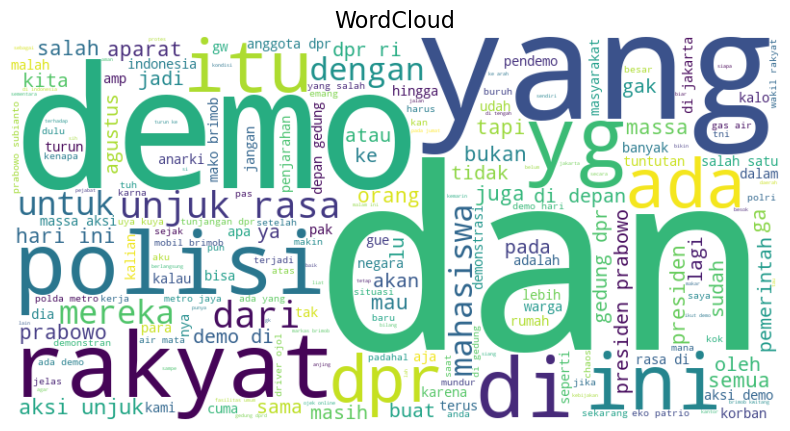

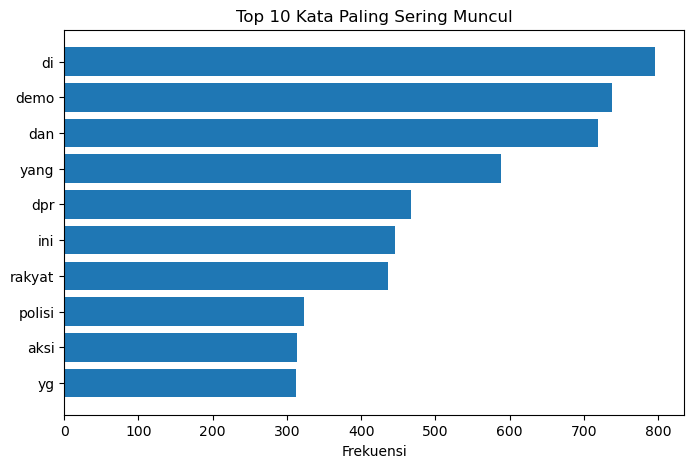

In [107]:
list_review = df_cleaned["cleaned_text"].to_list()
plot_wordcloud(list_review)
plot_top_words(list_review)

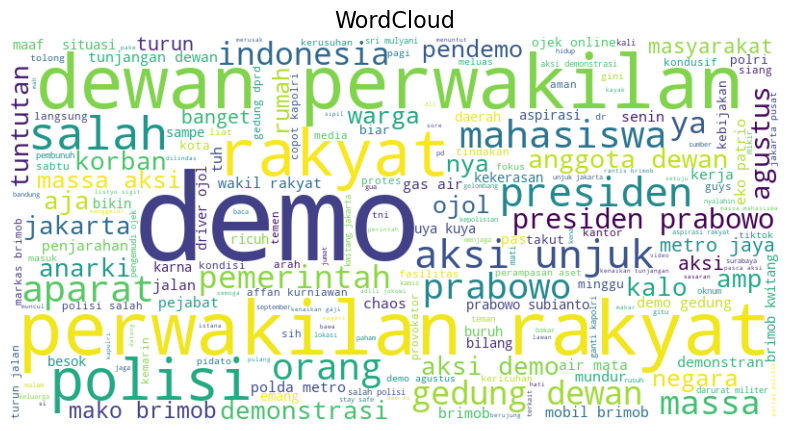

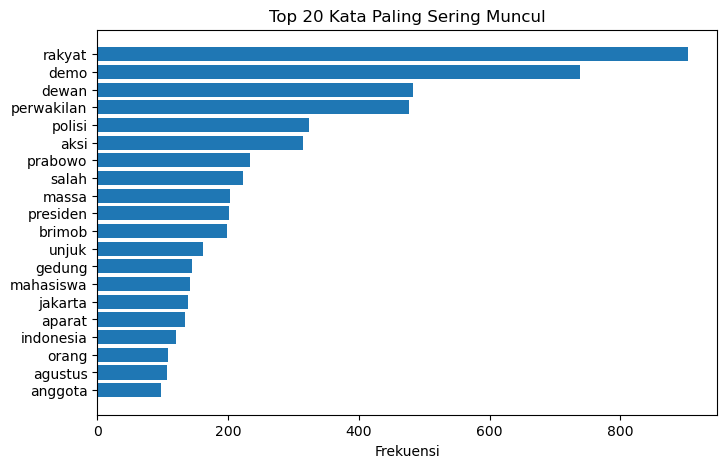

In [108]:
list_review = df_cleaned["cleaned_text_2"].to_list()
plot_wordcloud(list_review)
plot_top_words(list_review, n=20)

In [109]:
tokenizer = df['cleaned_text_2'].apply(lambda x: x.split())

In [110]:
tokenizer

0       [menyikapi, pernyataan, prabowo, pimpinan, lem...
1       [saudarasaudari, sebangsa, setanah, air, negar...
2       [ringkasan, pernyataan, presiden, menuduh, dem...
3       [musuh, fasilitas, perbedaan, suku, ras, agama...
4       [requiem, brutalitas, aparat, problem, struktu...
                              ...                        
1218    [mahasiswa, aksi, demo, didepan, gedung, dewan...
1219    [demo, bubarkan, dewan, perwakilan, rakyat, ev...
1220    [pantauan, demo, gedung, dewan, perwakilan, ra...
1221    [sepuluh, tuntutan, rakyat, indonesia, sepultu...
1222    [aksi, demo, gedung, dprmpr, ricuh, senin, sia...
Name: cleaned_text_2, Length: 1223, dtype: object

In [111]:
class Lemmatizer:
    def lemmatize(self, word):
        return Word(word).lemmatize()

sastrawi_stemmer = StemmerFactory().create_stemmer()
lemmatizer = Lemmatizer()

df_cleaned['tokenized_text'] = df_cleaned['cleaned_text_2'].apply(lambda x: x.split())
df_cleaned['stemmed_text'] = df_cleaned['cleaned_text_2'].apply(sastrawi_stemmer.stem)
df_cleaned['lemmatized_text'] = df_cleaned['tokenized_text'].apply(lambda tokens: ' '.join([lemmatizer.lemmatize(word) for word in tokens]))

print(df_cleaned[['cleaned_text_2', 'tokenized_text', 'stemmed_text', 'lemmatized_text']].head())

                                      cleaned_text_2  \
0  menyikapi pernyataan prabowo pimpinan lembaga ...   
1  saudarasaudari sebangsa setanah air negara men...   
2  ringkasan pernyataan presiden menuduh demonstr...   
3  musuh fasilitas perbedaan suku ras agama musuh...   
4  requiem brutalitas aparat problem struktural k...   

                                      tokenized_text  \
0  [menyikapi, pernyataan, prabowo, pimpinan, lem...   
1  [saudarasaudari, sebangsa, setanah, air, negar...   
2  [ringkasan, pernyataan, presiden, menuduh, dem...   
3  [musuh, fasilitas, perbedaan, suku, ras, agama...   
4  [requiem, brutalitas, aparat, problem, struktu...   

                                        stemmed_text  \
0  sikap nyata prabowo pimpin lembaga negara part...   
1  saudarasaudari bangsa tanah air negara hormat ...   
2  ringkas nyata presiden tuduh demonstrasi kemar...   
3  musuh fasilitas beda suku ras agama musuh kuas...   
4  requiem brutalitas aparat problem struktura

In [112]:
df_cleaned.to_csv("../data/hasil_scraping_demo/fix_scarap/cleaned_data_v2.csv", index=False)

In [113]:
df_cleaned

,created_at,favorite_count,full_text,quote_count,reply_count,retweet_count,hashtags,cleaned_text,cleaned_text_2,tokenized_text,stemmed_text,lemmatized_text
0,Sun Aug 31 14:43:43 +0000 2025,5677,Menyikapi pernyataan Prabowo bersama dengan pi...,54,87,3660,[],menyikapi pernyataan prabowo bersama dengan pi...,menyikapi pernyataan prabowo pimpinan lembaga ...,"[menyikapi, pernyataan, prabowo, pimpinan, lem...",sikap nyata prabowo pimpin lembaga negara part...,menyikapi pernyataan prabowo pimpinan lembaga ...
1,Sun Aug 31 10:11:46 +0000 2025,7435,Saudara-saudari sebangsa dan setanah air Negar...,4037,4287,1575,[],saudarasaudari sebangsa dan setanah air negara...,saudarasaudari sebangsa setanah air negara men...,"[saudarasaudari, sebangsa, setanah, air, negar...",saudarasaudari bangsa tanah air negara hormat ...,saudarasaudari sebangsa setanah air negara men...
2,Fri Aug 29 06:27:34 +0000 2025,14161,Ringkasan Pernyataan Presiden: 1. Menuduh demo...,2003,709,14116,[],ringkasan pernyataan presiden menuduh demonst...,ringkasan pernyataan presiden menuduh demonstr...,"[ringkasan, pernyataan, presiden, menuduh, dem...",ringkas nyata presiden tuduh demonstrasi kemar...,ringkasan pernyataan presiden menuduh demonstr...
3,Sat Aug 30 10:34:24 +0000 2025,4806,Musuh kita bukan fasilitas umum. Bukan perbeda...,34,65,1939,[],musuh kita bukan fasilitas umum bukan perbedaa...,musuh fasilitas perbedaan suku ras agama musuh...,"[musuh, fasilitas, perbedaan, suku, ras, agama...",musuh fasilitas beda suku ras agama musuh kuas...,musuh fasilitas perbedaan suku ra agama musuh ...
4,Sat Aug 30 06:44:02 +0000 2025,306,R E Q U I E M ● Brutalitas aparat bukan saja p...,1,30,93,[],requiem brutalitas aparat bukan saja problem ...,requiem brutalitas aparat problem struktural k...,"[requiem, brutalitas, aparat, problem, struktu...",requiem brutalitas aparat problem struktural k...,requiem brutalitas aparat problem struktural k...
...,...,...,...,...,...,...,...,...,...,...,...,...
1218,Thu Aug 28 07:51:29 +0000 2025,2541,Hari ini mahasiswa melakukan aksi demo lagi di...,17,41,562,[],hari ini mahasiswa melakukan aksi demo lagi di...,mahasiswa aksi demo didepan gedung dewan perwa...,"[mahasiswa, aksi, demo, didepan, gedung, dewan...",mahasiswa aksi demo depan gedung dewan wakil r...,mahasiswa aksi demo didepan gedung dewan perwa...
1219,Fri Aug 29 11:33:23 +0000 2025,1557,Demo Bubarkan DPR Evaluasi Pejabat Korup dan T...,15,23,540,[],demo bubarkan dpr evaluasi pejabat korup dan t...,demo bubarkan dewan perwakilan rakyat evaluasi...,"[demo, bubarkan, dewan, perwakilan, rakyat, ev...",demo bubar dewan wakil rakyat evaluasi jabat k...,demo bubarkan dewan perwakilan rakyat evaluasi...
1220,Mon Aug 25 05:43:50 +0000 2025,4135,Pantauan Demo di Gedung DPR RI tanggal 25 Agus...,48,49,1120,[],pantauan demo di gedung dpr ri tanggal agustu...,pantauan demo gedung dewan perwakilan rakyat t...,"[pantauan, demo, gedung, dewan, perwakilan, ra...",pantau demo gedung dewan wakil rakyat tanggal ...,pantauan demo gedung dewan perwakilan rakyat t...
1221,Sun Aug 31 22:36:49 +0000 2025,4441,SEPULUH TUNTUTAN RAKYAT UNTUK INDONESIA (SEPUL...,65,299,2135,[],sepuluh tuntutan rakyat untuk indonesia sepult...,sepuluh tuntutan rakyat indonesia sepultura de...,"[sepuluh, tuntutan, rakyat, indonesia, sepultu...",puluh tuntut rakyat indonesia sepultura demo s...,sepuluh tuntutan rakyat indonesia sepultura de...


# Translate

In [115]:
df_steam = df_cleaned[['stemmed_text']]

In [116]:
df_steam

,stemmed_text
0,sikap nyata prabowo pimpin lembaga negara part...
1,saudarasaudari bangsa tanah air negara hormat ...
2,ringkas nyata presiden tuduh demonstrasi kemar...
3,musuh fasilitas beda suku ras agama musuh kuas...
4,requiem brutalitas aparat problem struktural k...
...,...
1218,mahasiswa aksi demo depan gedung dewan wakil r...
1219,demo bubar dewan wakil rakyat evaluasi jabat k...
1220,pantau demo gedung dewan wakil rakyat tanggal ...
1221,puluh tuntut rakyat indonesia sepultura demo s...


In [117]:
from translate import Translator

def convert_to_english(text):
    translator = Translator(to_lang="en", from_lang="id")
    try:
        translation = translator.translate(text)
        return translation
    except Exception as e:
        print(f"Translation error: {e}")
        return text
    

df_steam['translated_text'] = df_steam['stemmed_text'].apply(convert_to_english)

KeyboardInterrupt: 

In [ ]:
df_steam.to_csv("../data/hasil_scraping_demo/fix_scarap/translated_data.csv", index=False)